In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
import requests
import json
import time

def get_all_scrobbles(api_key, username, limit=200, pages=1):
    all_scrobbles = []

    for page in range(1, pages + 1):
        url = f'http://ws.audioscrobbler.com/2.0/?method=user.getrecenttracks&user={username}&api_key={api_key}&format=json&page={page}&limit={limit}'

        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            scrobbles = data['recenttracks']['track']

            if not scrobbles:
                break  # No more scrobbles

            all_scrobbles.extend(scrobbles)
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break  # Stop if there's an error

        # Respect Last.fm API rate limits
        time.sleep(0.2)  # Adjust this value based on Last.fm's rate limit policy

    return all_scrobbles

# Replace 'YOUR_API_KEY' and 'YOUR_USERNAME' with your actual Last.fm API key and username
api_key = '4b8ccadc31915f4685b7fd653dfe2a5d'
username = 'demaNery'

# Set the number of pages based on your total scrobbles and the limit per page
total_pages = 10  # Adjust this based on your needs
scrobbles = get_all_scrobbles(api_key, username, pages=total_pages)

# Save the scrobbles to a JSON file
with open('scrobbles.json', 'w') as json_file:
    json.dump(scrobbles, json_file, indent=2)

print(f"Total scrobbles retrieved: {len(scrobbles)}")


Total scrobbles retrieved: 1867


In [89]:
import pandas as pd
import json

# Load scrobble data from the JSON file
with open('scrobbles.json') as json_file:
    scrobbles_data = json.load(json_file)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(scrobbles_data)


In [90]:
df.head()  # Display the first few rows
df.info()  # Get information about the DataFrame


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      1867 non-null   object
 1   streamable  1867 non-null   object
 2   image       1867 non-null   object
 3   mbid        1867 non-null   object
 4   album       1867 non-null   object
 5   name        1867 non-null   object
 6   url         1867 non-null   object
 7   date        1867 non-null   object
dtypes: object(8)
memory usage: 116.8+ KB


In [115]:
import pandas as pd

# Load scrobble data from the JSON file
with open('scrobbles.json') as json_file:
    scrobbles_data = json.load(json_file)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(scrobbles_data)

# Convert 'date' column to datetime format if not already done
if 'date' in df.columns and isinstance(df['date'][0], dict):
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x['#text']))

# Convert 'artist' and 'name' columns to strings
df['artist'] = df['artist'].astype(str)
df['name'] = df['name'].astype(str)

# Identify and filter out duplicates based on a subset of columns
subset_cols = ['artist', 'name', 'date']  # Adjust as needed
duplicate_mask = df.duplicated(subset=subset_cols, keep='first')

# Create a new DataFrame without duplicates
df_no_duplicates = df[~duplicate_mask].copy()
# Extract month names from the 'date' column
df_no_duplicates['month_name'] = df_no_duplicates['date'].dt.strftime('%B')

# Continue with the rest of the code
scrobbles_per_month = df_no_duplicates.groupby('month_name', observed=False).size().reset_index(name='scrobbles_count')



In [112]:
# Extract month from the 'date' column
df_no_duplicates['month'] = df_no_duplicates['date'].dt.month


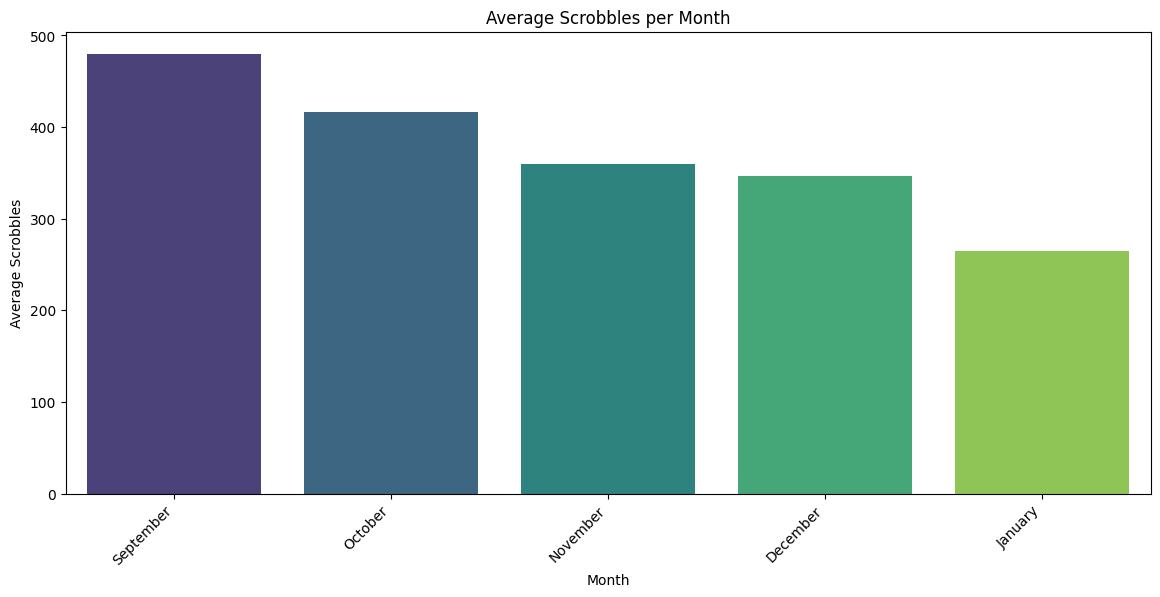

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table to get scrobbles per month
scrobbles_per_month = df_no_duplicates.groupby('month_name', observed=False).size().reset_index(name='scrobbles_count')

# Filter out months with zero scrobbles
non_empty_months_filtered = scrobbles_per_month[scrobbles_per_month['scrobbles_count'] > 0]['month_name']

# Order months based on the desired order
desired_month_order = ['September', 'October', 'November', 'December', 'January']
months_order_filtered = pd.Categorical(non_empty_months_filtered, categories=desired_month_order, ordered=True)

# Set the order for the 'month_name' column
df_no_duplicates['month_name'] = pd.Categorical(df_no_duplicates['month_name'], categories=desired_month_order, ordered=True)

# Filter the DataFrame to include only non-empty months
df_filtered = df_no_duplicates[df_no_duplicates['month_name'].isin(months_order_filtered)]

# Calculate average scrobbles per month (creating the DataFrame)
avg_scrobbles_month = df_filtered.groupby('month_name', observed=False)['artist'].count().reset_index(name='average_scrobbles')

# Set the order for the 'month_name' column in avg_scrobbles_month
avg_scrobbles_month['month_name'] = pd.Categorical(avg_scrobbles_month['month_name'], categories=desired_month_order, ordered=True)

# Plot average scrobbles per month (using the ordered 'month_name' column)
plt.figure(figsize=(14, 6))
sns.barplot(x='month_name', y='average_scrobbles', data=avg_scrobbles_month, palette='viridis', hue='month_name', legend=False)
plt.title('Average Scrobbles per Month')
plt.xlabel('Month')
plt.ylabel('Average Scrobbles')
plt.xticks(rotation=45, ha='right')  # Rotate month names for better readability
plt.show()

In [141]:
import pylast
import datetime
# Replace 'YOUR_API_KEY' and 'YOUR_API_SECRET' with your actual Last.fm API key and secret
API_KEY = '4b8ccadc31915f4685b7fd653dfe2a5d'
API_SECRET = '3fa13306b85d0757d3f91d5189d502ff'

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)

user = network.get_user('demaNery')


In [175]:
# Import Counter at the beginning of your script
from collections import Counter

# Define the target months
target_months = [9, 10, 11, 12, 1]  # September to January

# Fetch a reasonable number of recent tracks
recent_tracks = user.get_recent_tracks(limit=500)

# Print header
print("Month\tMost Played Genre\tCount")

for target_month in target_months:
    # Calculate the target date
    target_date = datetime.date(2024, target_month, 15)

    # Fetch all recent tracks once
    recent_tracks = user.get_recent_tracks(limit=None)

    # Filter tracks for the target month
    tracks_for_month = [
        track for track in recent_tracks if datetime.datetime.utcfromtimestamp(int(track.timestamp)).month == target_month
    ]

    # Extract tags for the month
    tags_for_month = set()
    for track in tracks_for_month:
        try:
            artist = str(track.track.artist)  # Ensure artist is a string
            if ' - ' in artist:
                artist = artist.split(" - ")[0]  # Use only the first part of the artist name
            print(f"Fetching tags for artist: {artist}")
            tags = network.get_artist(artist).get_top_tags()
            tags_for_month.update(tag.item.name.lower() for tag in tags)
        except Exception as e:
            print(f"Error processing track: {track.track} - {e}")

    # Convert tags_for_month to a set if it's a list
    tags_for_month = set(tags_for_month)

    # Print the summary for each month
    most_played_genre, count = Counter(tags_for_month).most_common(1)[0]
    print(f"{target_month}\t{most_played_genre}\t{count}")



Month	Most Played Genre	Count
Fetching tags for artist: Metallica
Fetching tags for artist: Megadeth
Fetching tags for artist: Megadeth
Fetching tags for artist: Kreator
Fetching tags for artist: Kreator
Fetching tags for artist: Mayhem
Fetching tags for artist: Soundgarden
Fetching tags for artist: R.E.M.
Fetching tags for artist: R.E.M.
Fetching tags for artist: Arctic Monkeys
Fetching tags for artist: My Chemical Romance
Fetching tags for artist: The Killers
Fetching tags for artist: The Offspring
Fetching tags for artist: beyaz hayvanlar
Fetching tags for artist: Lin Pesto
Fetching tags for artist: Lin Pesto
Fetching tags for artist: Blind Guardian
Fetching tags for artist: Blind Guardian
Fetching tags for artist: Blind Guardian
Fetching tags for artist: New Kids on the Block
Fetching tags for artist: Slayer
Fetching tags for artist: Metallica
Fetching tags for artist: Megadeth
Fetching tags for artist: Mayhem
Fetching tags for artist: Kxllswxtch
Fetching tags for artist: Kavinsky


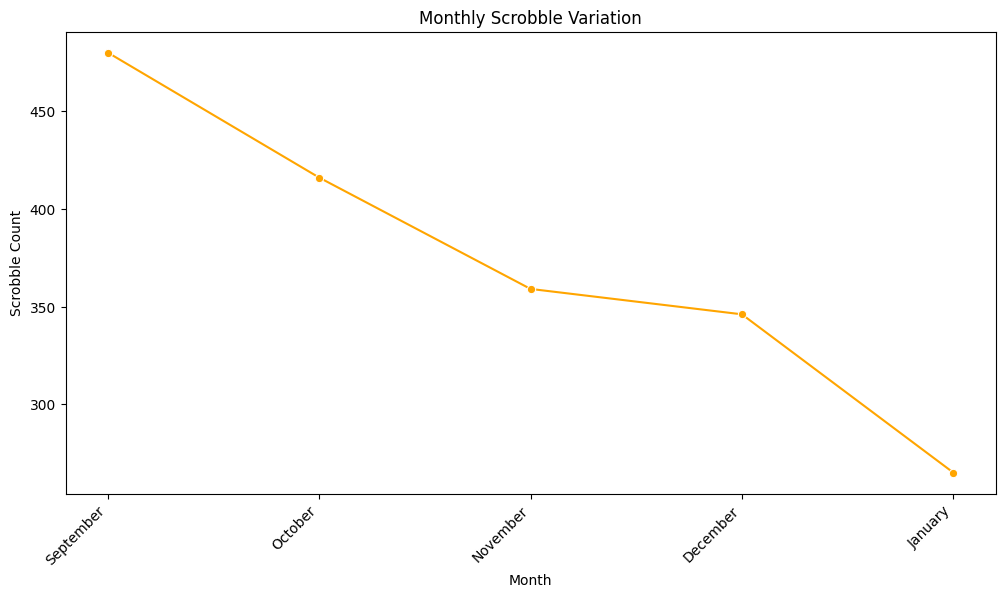

In [179]:
monthly_playcount = df_no_duplicates.groupby('month_name', observed=False)['artist'].count().reset_index(name='monthly_scrobbles')

plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='monthly_scrobbles', data=monthly_playcount, marker='o', color='orange')
plt.title('Monthly Scrobble Variation')
plt.xlabel('Month')
plt.ylabel('Scrobble Count')
plt.xticks(rotation=45, ha='right')
plt.show()